In [1]:
import os
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from pathlib import Path
from requests.auth import HTTPBasicAuth
from client import client_id, client_secret

In [2]:
# Path to folder Top Country CSV
rootdir = Path('Top Country CSV')

# Open folder and store each CSV file path into list
file_list = [f for f in rootdir.glob("*.csv") if f.is_file()]

In [3]:
## Authorization token to access spotify api (Required for all endpoints)
token_url = "https://accounts.spotify.com/api/token"
headers = {'content-type': 'application/x-www-form-urlencoded'}

token_params = {"grant_type" : "client_credentials"}

token_json = requests.post(token_url, params = token_params, headers = headers, auth = (client_id, client_secret)).json()
token = token_json['access_token']

In [4]:
token_headers = {'authorization': f"Bearer {token}"}

# Lists to store data
country = []
pop_popularity = []
rap_popularity = []
trap_popularity = []
other_popularity = []

# Search artist endpoint
search_artist_url = "https://api.spotify.com/v1/artists/"

# Loops through each file in list
for file in file_list:
    
    # Grab name of country from name of CSV file and append into country list
    country_name = str(file).split("\\")[-1].split("_")[0]
    country.append(country_name)
    
    # Convert each CSV file into DataFrame
    excel_df = pd.read_csv(file)
    
    # Start new count for each country
    pop_popularity.append(0)
    rap_popularity.append(0)
    trap_popularity.append(0)
    other_popularity.append(0)
    
    # Loops through each artist ID in DataFrame
    for artist_id in excel_df["Artist ID"]:
        artist_url = search_artist_url + artist_id
        
        # Time sleeper to prevent request errors
        time.sleep(0.01)
        
        try:
            artist_json = requests.get(artist_url, headers = token_headers).json()
            genres = artist_json["genres"]
            
            # Count for all three genres only if artist is labelled as all three
            if "pop" in genres and "rap" in genres and "trap music" in genres:
                pop_popularity[country.index(country_name)] += 1
                rap_popularity[country.index(country_name)] += 1
                trap_popularity[country.index(country_name)] += 1
            
            # Count for pop and rap only if artist is labelled as pop and rap
            elif "pop" in genres and "rap" in genres:
                pop_popularity[country.index(country_name)] += 1
                rap_popularity[country.index(country_name)] += 1
            
            # Count for pop and trap only if artist is labelled as pop and trap
            elif "pop" in genres and "trap music" in genres:
                pop_popularity[country.index(country_name)] += 1
                trap_popularity[country.index(country_name)] += 1
            
            # Count for rap and trap only if artist is labelled as rap and trap
            elif "rap" in genres and "trap music" in genres:
                rap_popularity[country.index(country_name)] += 1
                trap_popularity[country.index(country_name)] += 1
            
            # Count for pop if artist is only labelled as pop
            elif "pop" in genres:
                pop_popularity[country.index(country_name)] += 1
            
            # Count for rap if artist is only labelled as rap
            elif "rap" in genres:
                rap_popularity[country.index(country_name)] += 1
            
            # Count for trap if artist is only labelled as trap
            elif "trap music" in genres:
                trap_popularity[country.index(country_name)] += 1
            
            # Count for others if artist is neither genres
            else:
                other_popularity[country.index(country_name)] += 1
                
        except (KeyError, IndexError):
            print(f"Artist ID not working | {artist_id}")

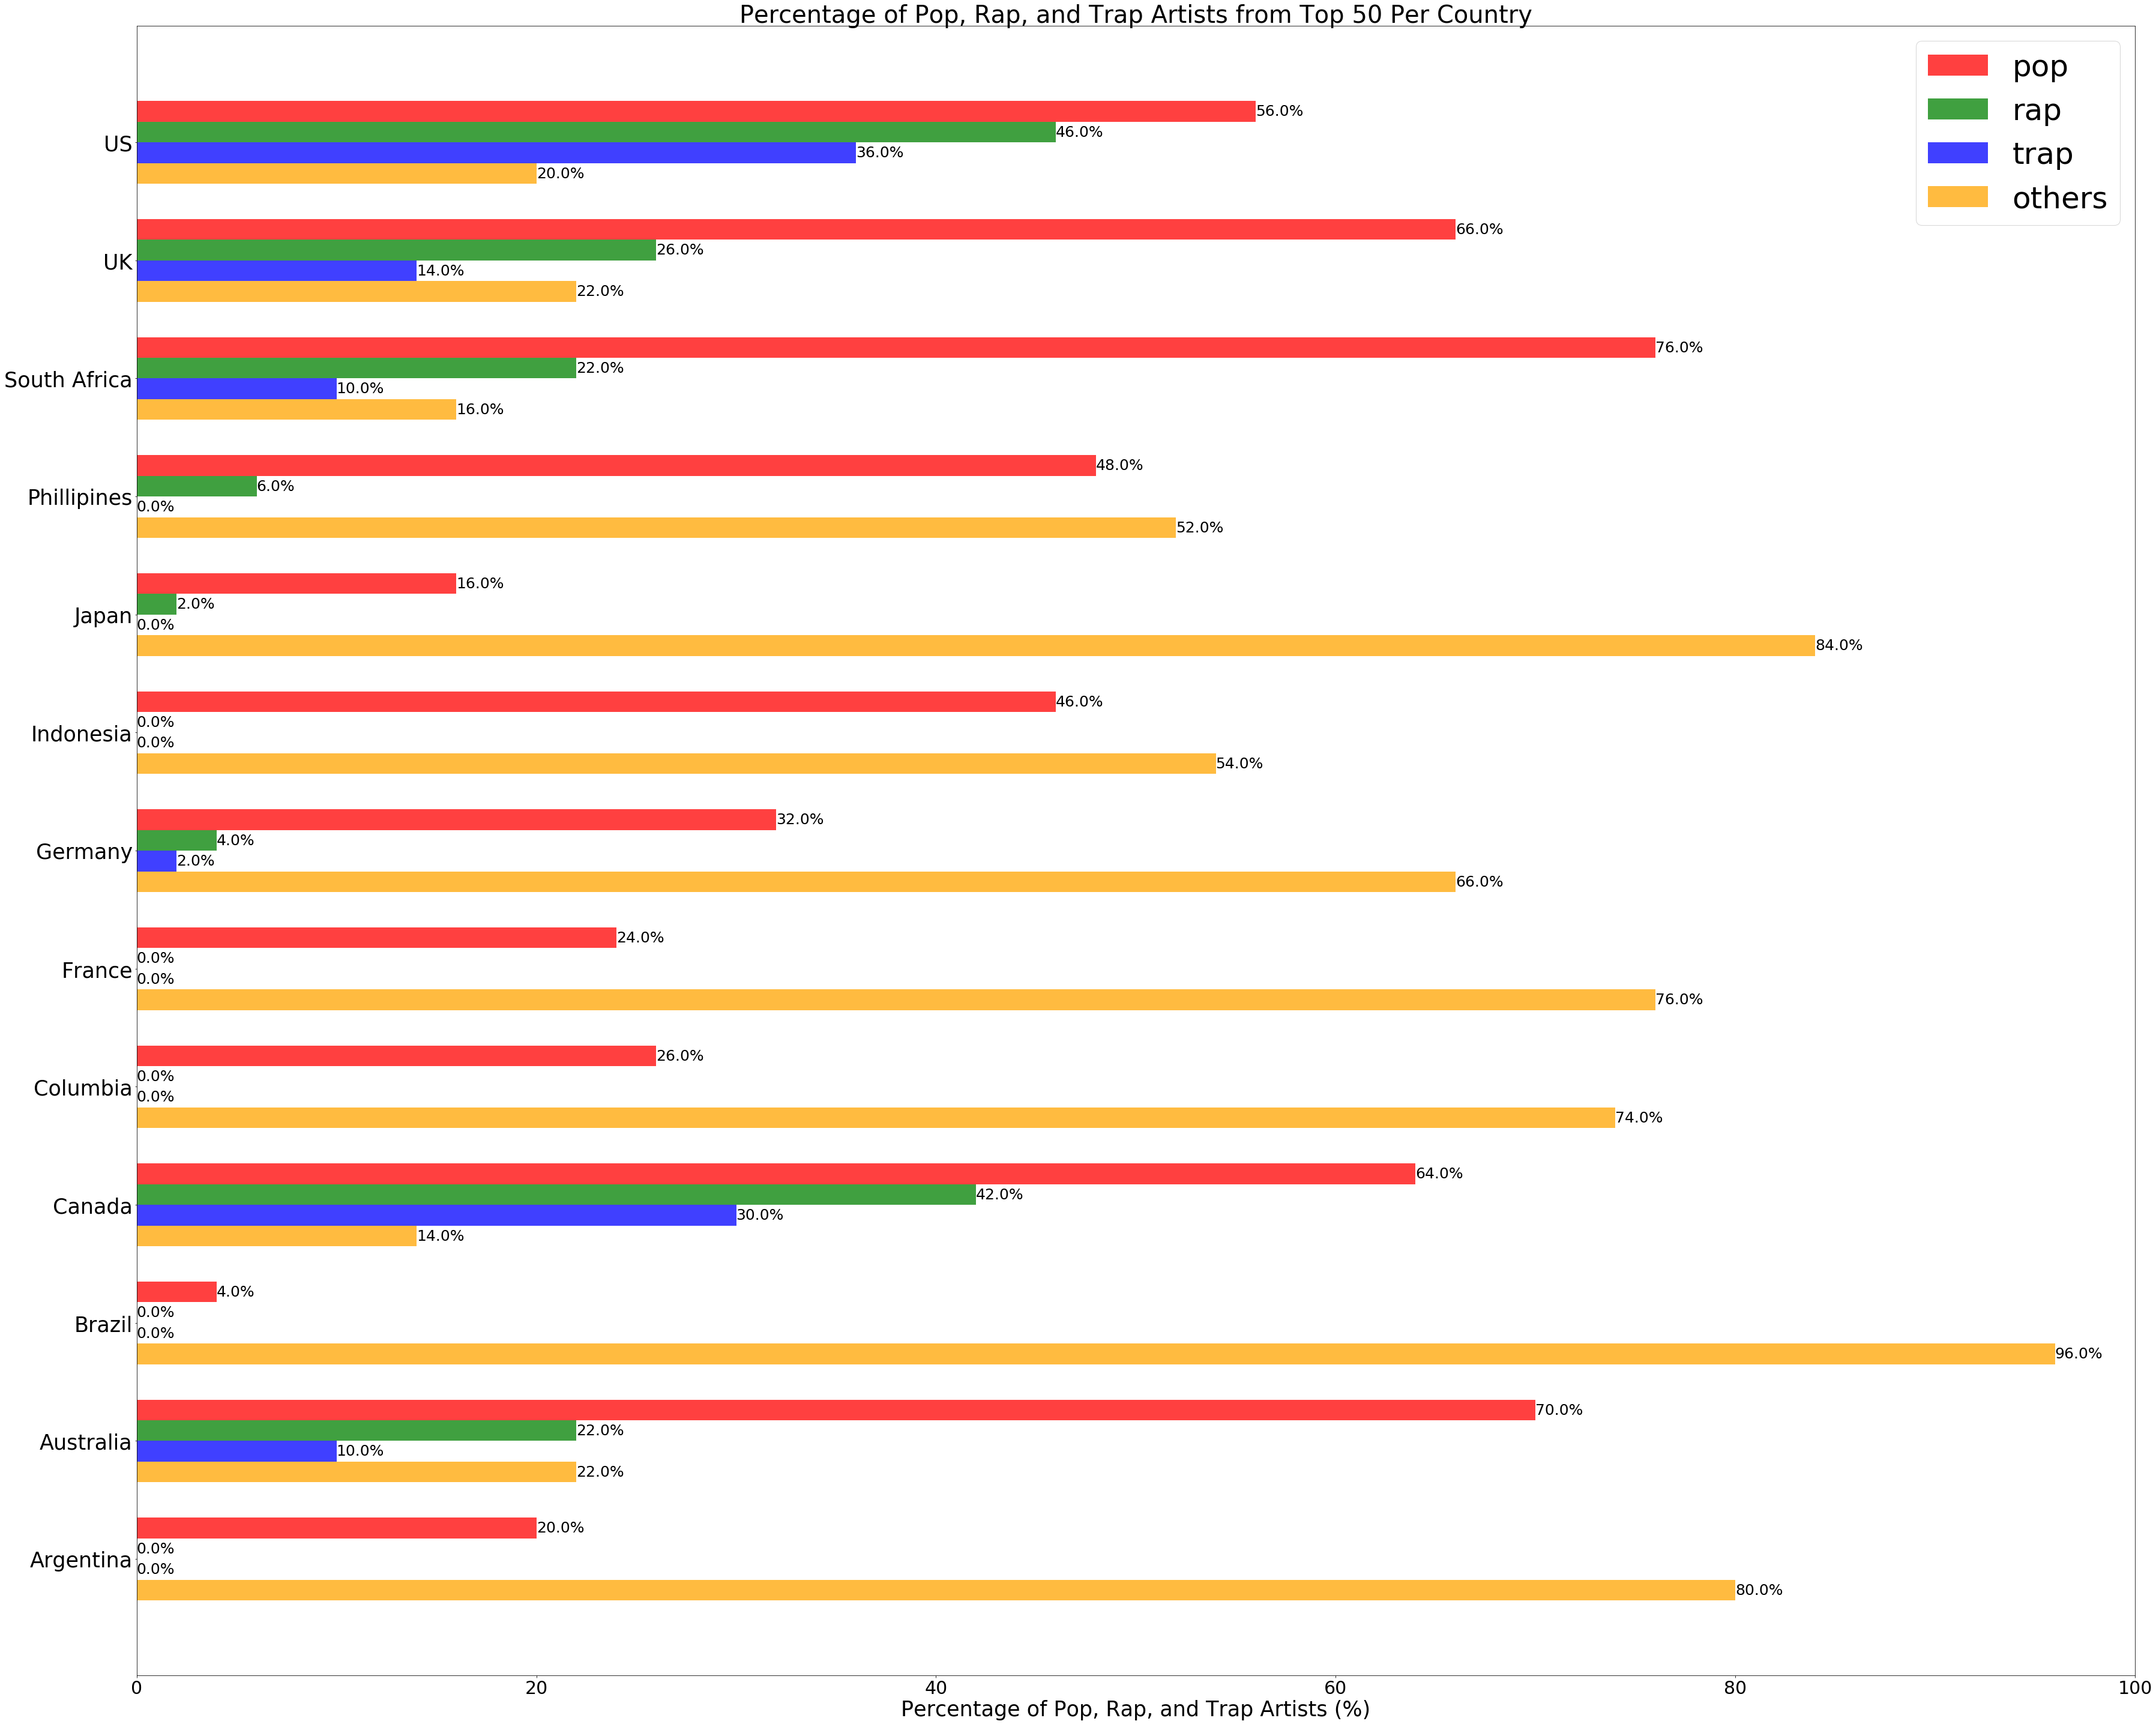

In [5]:
# Create figure and size
fig, ax = plt.subplots(figsize = (50,40))

# Y-Axis: All countries obersved
y_axis = np.arange(0, len(country) * 4, 4)

# Create width of bars for bar graph
width = 0.7

# Each country has four bars total for the four genres (pop, rap, trap and others)
x_axis_pop = (np.array(pop_popularity)/50) * 100
x_axis_rap = (np.array(rap_popularity)/50) * 100
x_axis_trap = (np.array(trap_popularity)/50) * 100
x_axis_other = (np.array(other_popularity)/50) * 100

# Set each bar side by side according to box width
ax.barh(y_axis + width + width/2, x_axis_pop, width, color = 'r', alpha = 0.75, label = "pop")
ax.barh(y_axis + width/2, x_axis_rap, width, color = 'g', alpha = 0.75, label = "rap")
ax.barh(y_axis - width/2, x_axis_trap, width, color = 'b', alpha = 0.75, label = "trap")
ax.barh(y_axis - width - width/2, x_axis_other, width, color = 'orange', alpha = 0.75, label = "others")

# Labels and fontsize
plt.yticks(y_axis, country, Fontsize = 35)
plt.xticks(Fontsize = 30)
plt.xlim(0,100)
plt.xlabel("Percentage of Pop, Rap, and Trap Artists (%)", Fontsize = 35)
plt.title("Percentage of Pop, Rap, and Trap Artists from Top 50 Per Country", Fontsize = 40)
ax.legend(loc = "best", prop={'size': 50})

# Get dimensions of each box
rects = ax.patches

for rect in rects:
    
    # Box width from horizontal graph
    box_width = rect.get_height()
    
    # Box height from horizontal graph
    height = rect.get_y() + box_width / 2
    
    # Box outer right edge
    edge = rect.get_width()
    
    if edge >= 0:
        ax.text(edge, height, f'{round(edge,2)}%', Fontsize = 25, ha = 'left', va = 'center')
    else:
        ax.text(edge, height, f'{round(edge,2)}%', Fontsize = 25, ha = 'right', va = 'center')

# Save figure
plt.savefig("Images/Percentage_of_Top_3_US_Genre_Per_Country.png")

plt.tight_layout()
    
plt.show()